In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
test_data = pd.read_csv('data/test_data_annot.csv')

In [3]:
test_data.head(n=10)

,chr,start,end,seq1,seq2,label,Median_sequence,GC,length,DNase,ATAC,H3K27ac,H3K4me3,DeepSpCas9_harmony,DeepCRISPR_harmony,CRISPRedict_harmony,Ruleset2_harmony,hyena_score
0,chr2,48440797,48440893,CGCCGCGCCTCCTCCTCCACTTCCGGGTTC,TTCCCGGGAGCGTGTCTGGGTTTGGGGGCG,1,AGTGGAGGAGGAGGCGCGGCGGCGGCGGCGGCGGCGGCTGCGGTGG...,0.729167,96,123332.744881,452.250715,9706.735352,16793.294783,4.431776,0.719472,1.736863,3.536433,-2.889551
1,chr7,5072216,5072322,GTGACTGGTCCGTGGGCTAACTCAGGGCTG,GCAGAGAGGAAAGGGCGTGAAGAGGGGGCG,1,AGGGCTGCTCGGGAGACATAGGCGGGCCGTGGGGGCAGGTGAAGGG...,0.669811,106,1910.800738,69.262120,0.000000,1901.978917,4.398179,0.718165,3.907437,4.064390,-3.844674
2,chr7,5072216,5072322,GCAGAGAGGAAAGGGCGTGAAGAGGGGGCG,GTGACTGGTCCGTGGGCTAACTCAGGGCTG,0,AGGGCTGCTCGGGAGACATAGGCGGGCCGTGGGGGCAGGTGAAGGG...,0.669811,106,1910.800738,69.262120,0.000000,1901.978917,4.382854,0.718165,3.898184,4.076555,-3.844674
3,chr2,46541807,46541911,AGATGGGTGTGTTCCGGCATCGCCAGGCAG,ACGGAATACCTTTGAGGAACATTGGGGACC,1,CAGGCAGAGGGGCAGGGGTTGCCGCCTCGAGCACAGGCCAAGTTTC...,0.538462,104,30556.754856,58.236825,17334.260518,16806.170692,4.380051,0.716701,2.081634,3.428387,-3.699923
4,chr2,46541807,46541911,ACGGAATACCTTTGAGGAACATTGGGGACC,AGATGGGTGTGTTCCGGCATCGCCAGGCAG,0,CAGGCAGAGGGGCAGGGGTTGCCGCCTCGAGCACAGGCCAAGTTTC...,0.538462,104,30556.754856,58.236825,17334.260518,16806.170692,4.378488,0.716701,2.081103,3.414082,-3.699923
5,chr2,46541807,46541911,ACGGAATACCTTTGAGGAACATTGGGGACC,AGATGGGTGTGTTCCGGCATCGCCAGGCAG,0,CAGGCAGAGGGGCAGGGGTTGCCGCCTCGAGCACAGGCCAAGTTTC...,0.538462,104,30556.754856,58.236825,17334.260518,16806.170692,4.378488,0.716701,2.081103,3.414082,-3.699923
6,chr7,5607353,5607456,GATAGCAGCTGCGAGAAGACTGAGGGGAGG,CTGTCCCTGCAGCCTAGGATGCAAAGGGAG,1,CATCCTAGGCTGCAGGGACAGGGGCTGGGCAGAGGCTCGCGGACCT...,0.621359,103,3816.656758,67.342133,2301.324533,2534.978231,4.311299,0.713438,2.803987,2.622306,-3.937159
7,chr7,5607353,5607456,GATAGCAGCTGCGAGAAGACTGAGGGGAGG,CTGTCCCTGCAGCCTAGGATGCAAAGGGAG,1,CATCCTAGGCTGCAGGGACAGGGGCTGGGCAGAGGCTCGCGGACCT...,0.621359,103,3816.656758,67.342133,2301.324533,2534.978231,4.311299,0.713438,2.803987,2.622306,-3.937159
8,chr3,46372159,46372259,ATTGGCATCCAGTATGTGCCCTCGAGGCCT,AGACTGAGTTGCAGCCGGGCATGGTGGCTC,0,GAGGCCTCTTAATTATTACTGGCTTGCTCATAGTGCATGTTCTTTG...,0.440000,100,301.381396,14.872258,1183.182586,458.406610,4.285287,0.712808,3.871828,3.438448,-3.522517
9,chr7,5607305,5607456,GATAGCAGCTGCGAGAAGACTGAGGGGAGG,CCTGACTGTGGCCTTGGTAAAGTCTGGAAA,1,TTTACCAAGGCCACAGTCAGGGCGACCTGGGTTCTGAGCCTCCCTT...,0.609272,151,3745.180017,68.042053,2349.736705,2443.449301,4.215512,0.708976,2.957499,2.796193,-3.006579


In [9]:
target_column = 'label'
features =  ['DNase','ATAC','H3K27ac','H3K4me3','GC','length',
             'DeepSpCas9_harmony','DeepCRISPR_harmony','Ruleset2_harmony','CRISPRedict_harmony',
             'hyena_score'
            ]
# 提取特征和目标值
X = test_data[features].values
Y = test_data[target_column].values

# 数据划分
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1919810)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

params = {
    'objective': 'reg:squarederror',  # 回归问题
    'eval_metric': 'auc',             # 使用AUC评估
    'eta': 0.05,                      # 学习率
    'max_depth': 15,                  # 树的最大深度
    'subsample': 0.8,                 # 数据采样比率
    'colsample_bytree': 0.8,          # 每棵树的列采样比率
    'device':'cpu'                    # 训练设备
}


# 训练模型
num_round = 200  # 训练轮数
bst = xgb.train(params, dtrain, num_round)

# 进行预测
Y_pred = bst.predict(dtest)

# 评估模型性能
rmse = mean_squared_error(Y_test, Y_pred, squared=False)
r2 = r2_score(Y_test, Y_pred)

print(f'RMSE: {rmse}')
print(f'R2: {r2}')

AUC: 0.8884536377967802


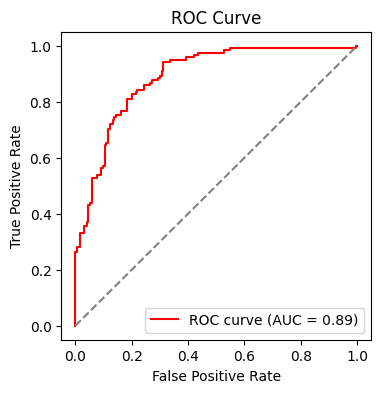

In [14]:
y_pred_proba = bst.predict(dtest)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc}')

# 绘制 ROC 曲线
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 对角线（随机分类器的性能）
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()